In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""
test=""
z_diff=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "uber"
z_range = "all_z"
key = ""
quantile = ""
test = "foreground"
z_diff = 0.1


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
z_diff=float(z_diff)

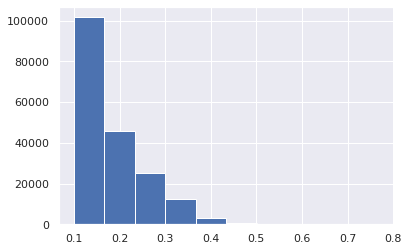

In [5]:
if test=="foreground":
    members=shapes[(shapes[('All','Z')]-shapes[('All','ZRED2')])>=z_diff]
    diff=members[('All','Z')]-members[('All','ZRED2')]
    diff.hist()
    diff.describe()
    
elif test=="background":
    members=background=shapes[(shapes[('All','Z')]-shapes[('All','ZRED2')])<=-z_diff]
    diff=members[('All','Z')]-members[('All','ZRED2')]
    diff.hist()
    diff.describe()
elif test=="":
    members=shapes
else:
    raise TypeError

In [6]:
if vol!="uber":
    members=shapes

In [7]:
if quantile!="":
    i=int(quantile)

In [8]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [9]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [10]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [11]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [12]:
NBINS=10

In [13]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [14]:
len(shapes)

1079244

In [15]:
len(members)

189830

In [16]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [17]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=members[members['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [18]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [19]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [20]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

12472it [02:34, 80.78it/s]
9it [00:00, 88.19it/s]

Number of empty sat catalogs is 608


12472it [02:06, 98.98it/s] 

Number of empty sat catalogs is 608


In [21]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [22]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [23]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [24]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [25]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [26]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [27]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [28]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [29]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

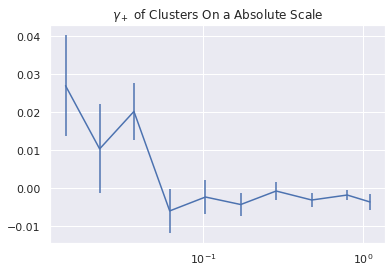

Aggregated xi:
[ -7.9222  -8.9815 -29.3055  15.956   12.461   46.4962  14.8193 120.7278
 125.6021 121.4313]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -1255.0965  -3273.2904  -4770.6906  -7509.7881 -12527.8058 -19344.4228
 -27253.6898 -29308.7009 -16607.7372   3324.1463]
------------------------------------------------------------------------------
Aggregated npairs:
[  293.   863.  1446.  2697.  5520. 10978. 21759. 39611. 72416. 34161.]
------------------------------------------------------------------------------
Mean xi:
[-0.027  -0.0104 -0.0203  0.0059  0.0023  0.0042  0.0007  0.003   0.0017
  0.0036]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.2836 -3.7929 -3.2992 -2.7845 -2.2695 -1.7621 -1.2525 -0.7399 -0.2293
  0.0973]
------------------------------------------------------------------------------


In [30]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

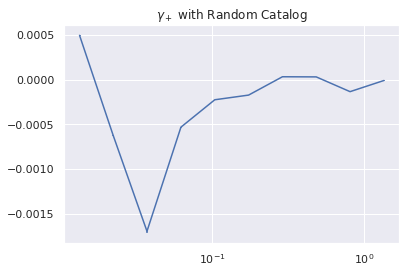

[ 4.9332e-04 -6.2438e-04 -1.6901e-03 -5.3002e-04 -2.2471e-04 -1.7261e-04
  3.1751e-05  3.0225e-05 -1.3427e-04 -1.0015e-05]
[-4.4173e-06  5.5909e-06  1.5134e-05  4.7459e-06  2.0121e-06  1.5456e-06
 -2.8431e-07 -2.7065e-07  1.2023e-06  8.9676e-08]


In [31]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

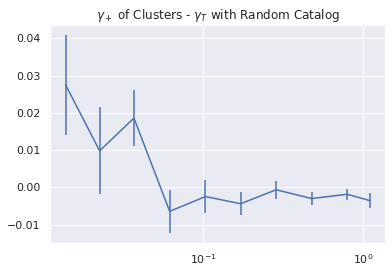

In [32]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

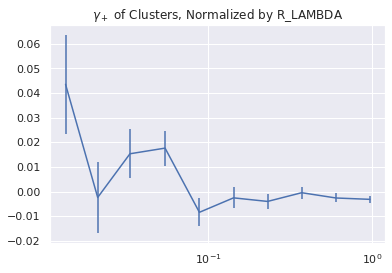

Aggregated xi:
[ -4.1797   1.0902 -15.3137 -29.009   24.551   15.1258  44.6953  10.267
  95.8146 202.2303]
------------------------------------------------------------------------------
Aggregated meanlogr:
[  -412.6751  -1743.2927  -3392.7326  -4780.775   -7047.6913 -11420.8561
 -16298.8584 -20856.1885 -18528.3497  -2227.3865]
------------------------------------------------------------------------------
Aggregated npairs:
[   96.   453.   999.  1646.  2908.  5870. 11100. 21056. 36384. 63625.]
------------------------------------------------------------------------------
Mean xi:
[-0.0435  0.0024 -0.0153 -0.0176  0.0084  0.0026  0.004   0.0005  0.0026
  0.0032]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.2987 -3.8483 -3.3961 -2.9045 -2.4236 -1.9456 -1.4684 -0.9905 -0.5092
 -0.035 ]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [33]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)